In [82]:
# imports needed for EDA on Fashion Products Dataset
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# imports for baseline model
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# visualization settings
%matplotlib inline
sns.color_palette(palette='Set3')
sns.set(color_codes=True)

# path settings
csv_path = "../data/styles.csv"
img_base_path = "../data/images/"

# Exploratory Data Analysis on Fashion Products Dataset

In [83]:
df = pd.read_csv(csv_path, on_bad_lines="skip")
df.head(5) # display first 5 rows

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [84]:
# data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


Obs: Only Categorical data in CSV

In [85]:
# Unique values inspection
df.nunique()

id                    44424
gender                    5
masterCategory            7
subCategory              45
articleType             143
baseColour               46
season                    4
year                     13
usage                     8
productDisplayName    31121
dtype: int64

In [86]:
# Display unique values per column except ID

# Get columns except 'id' & 'productDisplayName'
cols = [col for col in df.columns if (col != 'id' and col != 'productDisplayName')]

# 1. Get unique values for each column except ID
unique_values = [df[col].unique() for col in cols]

# 2. Find the maximum length
max_unique = max(len(u) for u in unique_values)

# 3. Pad each list for equal length
unique_values_padded = [list(u) + [pd.NA]*(max_unique - len(u)) for u in unique_values]

# 4. Create the DataFrame (without ID column)
unique_df = pd.DataFrame(data=dict(zip(cols, unique_values_padded)))

unique_df

,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage
0,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual
1,Women,Accessories,Bottomwear,Jeans,Blue,Summer,2012.0,Ethnic
2,Boys,Footwear,Watches,Watches,Silver,Winter,2016.0,Formal
3,Girls,Personal Care,Socks,Track Pants,Black,Spring,2017.0,Sports
4,Unisex,Free Items,Shoes,Tshirts,Grey,NaN,2015.0,NaN
...,...,...,...,...,...,...,...,...
138,<NA>,<NA>,<NA>,Mens Grooming Kit,<NA>,<NA>,<NA>,<NA>
139,<NA>,<NA>,<NA>,Rain Trousers,<NA>,<NA>,<NA>,<NA>
140,<NA>,<NA>,<NA>,Body Wash and Scrub,<NA>,<NA>,<NA>,<NA>
141,<NA>,<NA>,<NA>,Suits,<NA>,<NA>,<NA>,<NA>


In [87]:
# Check for missing values
df.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [ ]:
# Dataframe shape
print("Dataframe shape (rows, columns):", df.shape) 
# Check for duplicates
print("Number of duplicate rows:", df.duplicated().sum())

Dataframe shape (rows, columns): (44424, 10)
Number of duplicate rows: 0


       id  gender masterCategory       subCategory articleType baseColour  \
449  6845  Unisex    Accessories  Shoe Accessories  Shoe Laces      Black   

     season    year   usage                                 productDisplayName  
449  Summer  2011.0  Casual  Timberland Unisex Hiker Round Lace Shoe Access...  


(np.float64(-0.5), np.float64(59.5), np.float64(79.5), np.float64(-0.5))

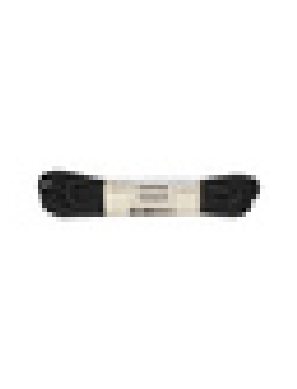

In [88]:
# Rare category inspection
rare_category = df['articleType'].value_counts().idxmin()
print(df[df['articleType'] == rare_category].head())

# Display an image from the rare category
img = mpimg.imread(f"{img_base_path}{df[df['articleType'] == rare_category]['id'].values[0]}.jpg")
plt.imshow(img)
plt.axis('off')

In [89]:
# Bad labels inspection in all columns
bad_labels = ['NA', 'none', 'nan', None, np.nan, '']
for col in cols:
    print(f"Column: {col}")
    for bad in bad_labels:
        count = (df[col] == bad).sum()
        if count > 0:
            print(f"  Bad label '{bad}': {count} occurrences")
    print()

Column: gender

Column: masterCategory

Column: subCategory

Column: articleType

Column: baseColour

Column: season

Column: year

Column: usage



## EDA Visualization

In [63]:
# Crosstab between gender and articleType
pd.crosstab(df['gender'], df['articleType']).head()

articleType,Accessory Gift Set,Baby Dolls,Backpacks,Bangle,Basketballs,Bath Robe,Beauty Accessory,Belts,Blazers,Body Lotion,...,Trunk,Tshirts,Tunics,Umbrellas,Waist Pouch,Waistcoat,Wallets,Watches,Water Bottle,Wristbands
gender,,,,,,,,,,,,,,,,,,,,,
Boys,0,0,0,0,0,0,0,0,1,0,...,0,531,0,0,0,3,0,8,0,0
Girls,0,0,2,0,0,0,0,0,0,0,...,0,106,0,0,0,0,0,16,0,0
Men,97,0,55,14,0,0,0,541,5,0,...,140,5243,1,0,1,7,450,1473,4,0
Unisex,0,0,631,0,13,0,0,9,0,0,...,0,71,0,0,16,0,21,143,7,7
Women,0,16,36,71,0,20,4,263,2,6,...,0,1116,228,6,0,5,465,902,0,0


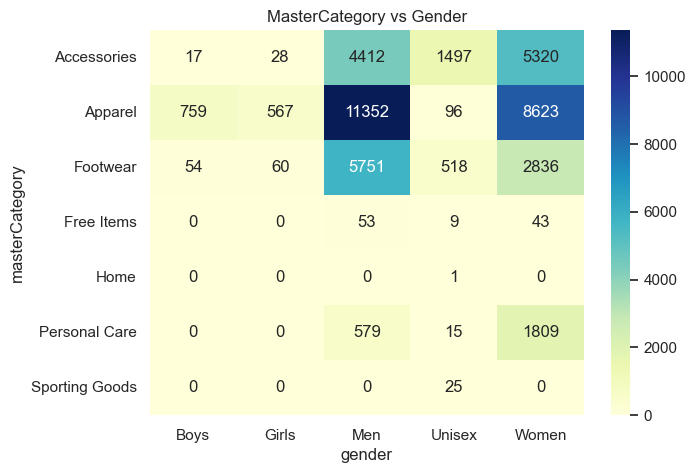

In [ ]:
# Heatmap for MasterCategory vs Gender
ct = pd.crosstab(df['masterCategory'], df['gender'])
plt.figure(figsize=(7, 5))
sns.heatmap(ct, annot=True, cmap="YlGnBu", fmt="d")
plt.title('MasterCategory vs Gender')
plt.show()

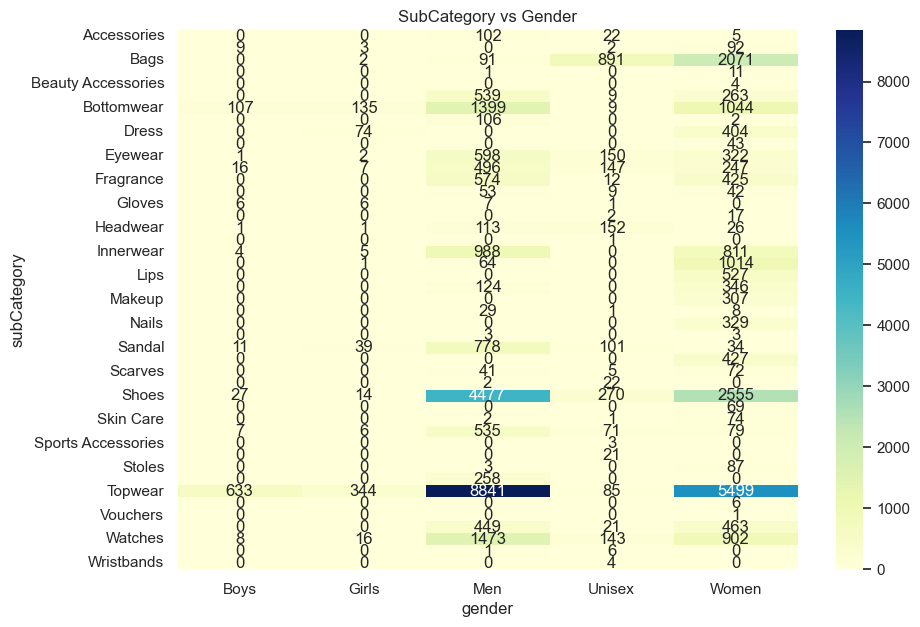

In [67]:
# heatmap for SubCategory vs Gender
ct = pd.crosstab(df['subCategory'], df['gender'])
plt.figure(figsize=(10, 7))
sns.heatmap(ct, annot=True, cmap="YlGnBu", fmt="d")
plt.title('SubCategory vs Gender')
plt.show()

<Axes: xlabel='articleType'>

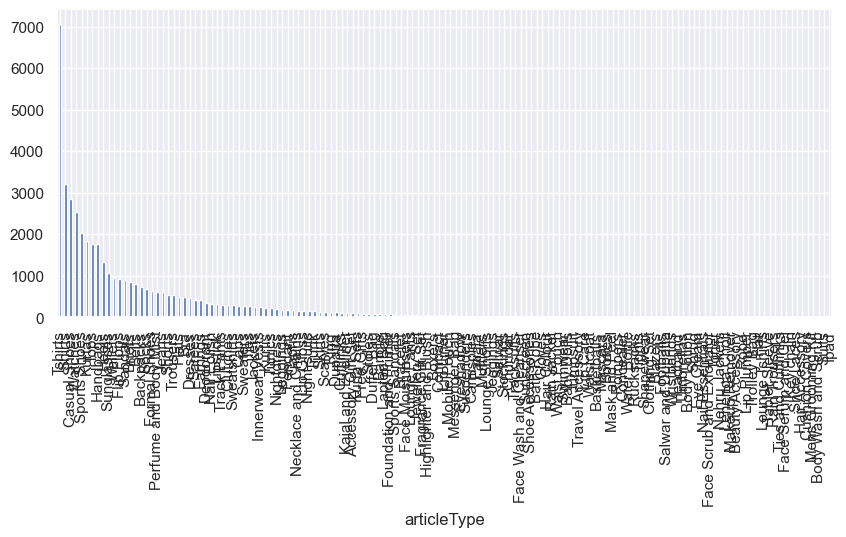

In [61]:
df['articleType'].value_counts().plot(kind='bar', figsize=(10,4))

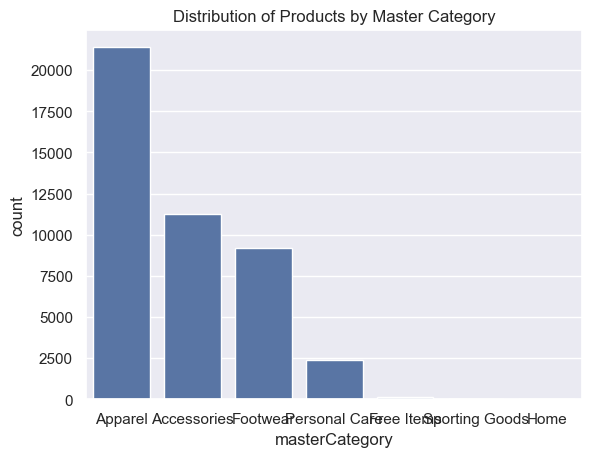

In [32]:
sns.countplot(x='masterCategory', data=df)
plt.title('Distribution of Products by Master Category')
plt.show()

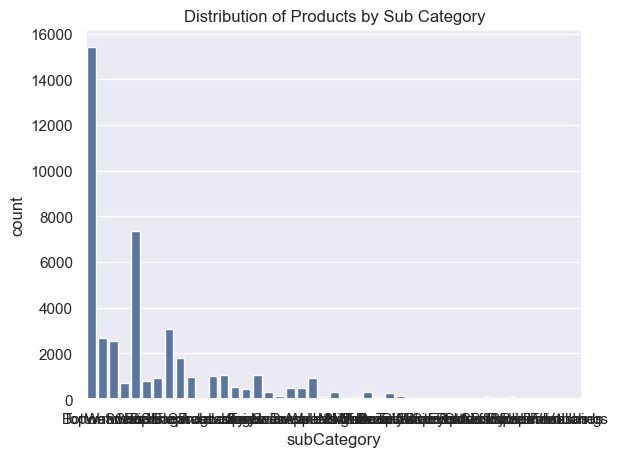

In [28]:
sns.countplot(x='subCategory', data=df)
plt.title('Distribution of Products by Sub Category')
plt.show()

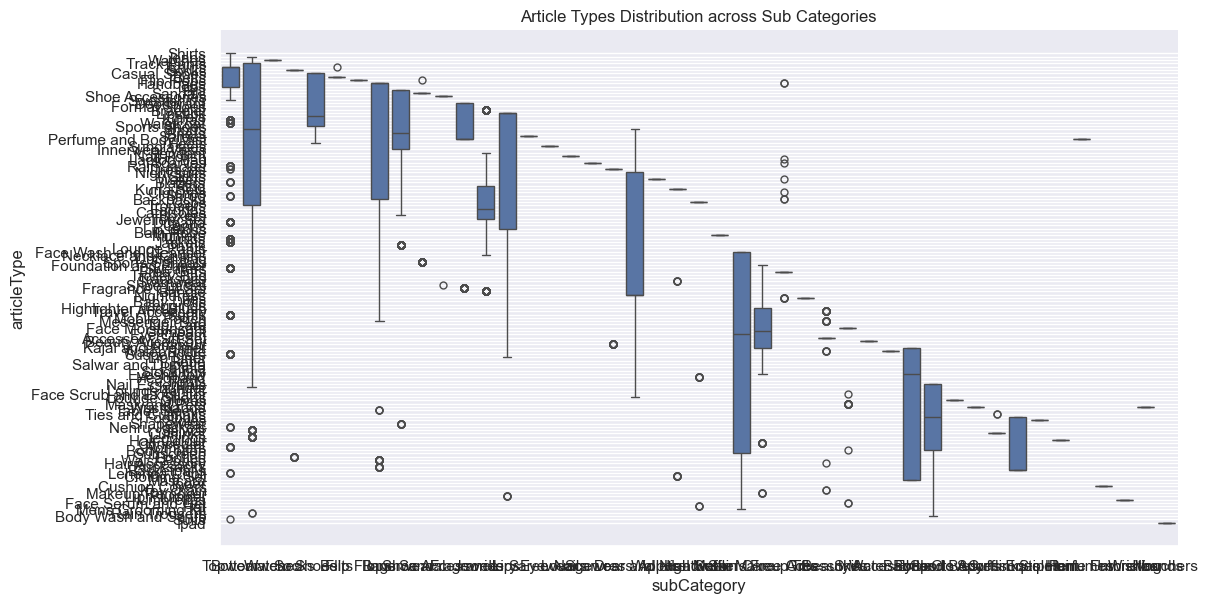

In [30]:
sns.catplot(x='subCategory', y='articleType', data=df, kind='box', height=6, aspect=2)
plt.title('Article Types Distribution across Sub Categories')
plt.show()

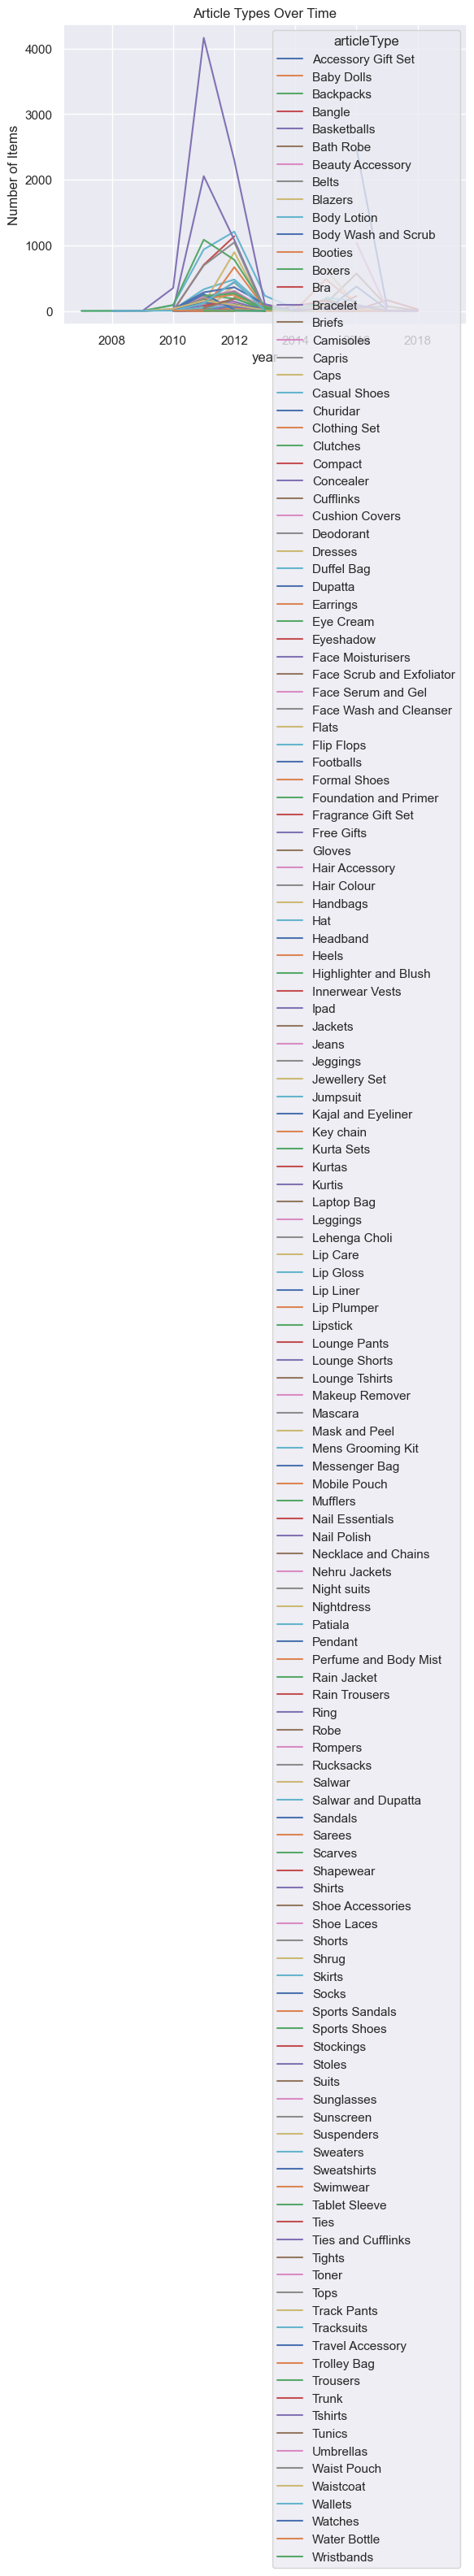

In [93]:
# Trend of article types over years
df.groupby(['year', 'articleType']).size().unstack().plot(kind='line')
plt.title('Article Types Over Time')
plt.ylabel('Number of Items')
plt.show()

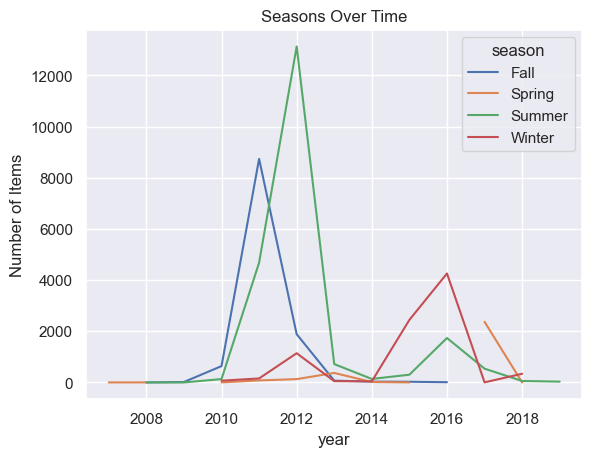

In [94]:
# Trend of seasons over years
df.groupby(['year', 'season']).size().unstack().plot(kind='line')
plt.title('Seasons Over Time')
plt.ylabel('Number of Items')
plt.show()

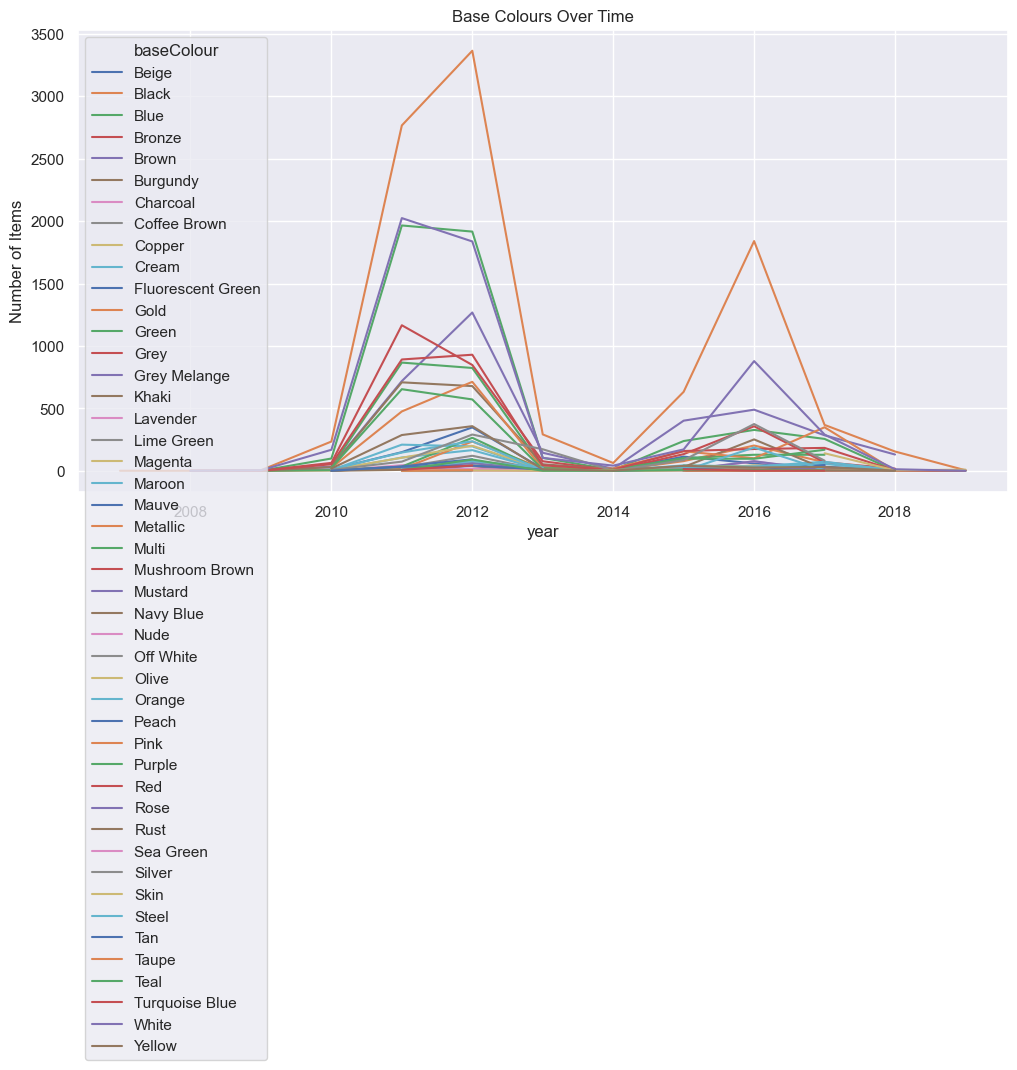

In [95]:
# Trend of colors over years
df.groupby(['year', 'baseColour']).size().unstack().plot(kind='line', figsize=(12,6))
plt.title('Base Colours Over Time')
plt.ylabel('Number of Items')
plt.show()


### PCA EDA

In [92]:
# Prepare data for PCA
X = df.drop(columns=['id', 'productDisplayName'])  # features are all other columns except 'id' and 'productDisplayName'
y = df['articleType']  # target/label is 'articleType'

In [ ]:
# Clean data: drop rows with missing values
X = X.dropna()
y = y[X.index]  # align y with cleaned X

: 

: 

In [ ]:
# Encode categorical variables and scale features
X_encoded = pd.get_dummies(X)  # Each unique value becomes a separate column
X_scaled = StandardScaler().fit_transform(X_encoded)  # Standardize features

: 

: 

In [ ]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

: 

: 

In [ ]:
# Make a DataFrame for easier plotting
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['articleType'] = y.values

: 

: 

C:\Users\Aishu\AppData\Local\Temp\ipykernel_15732\2818301369.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()   # To prevent labels from getting cut off


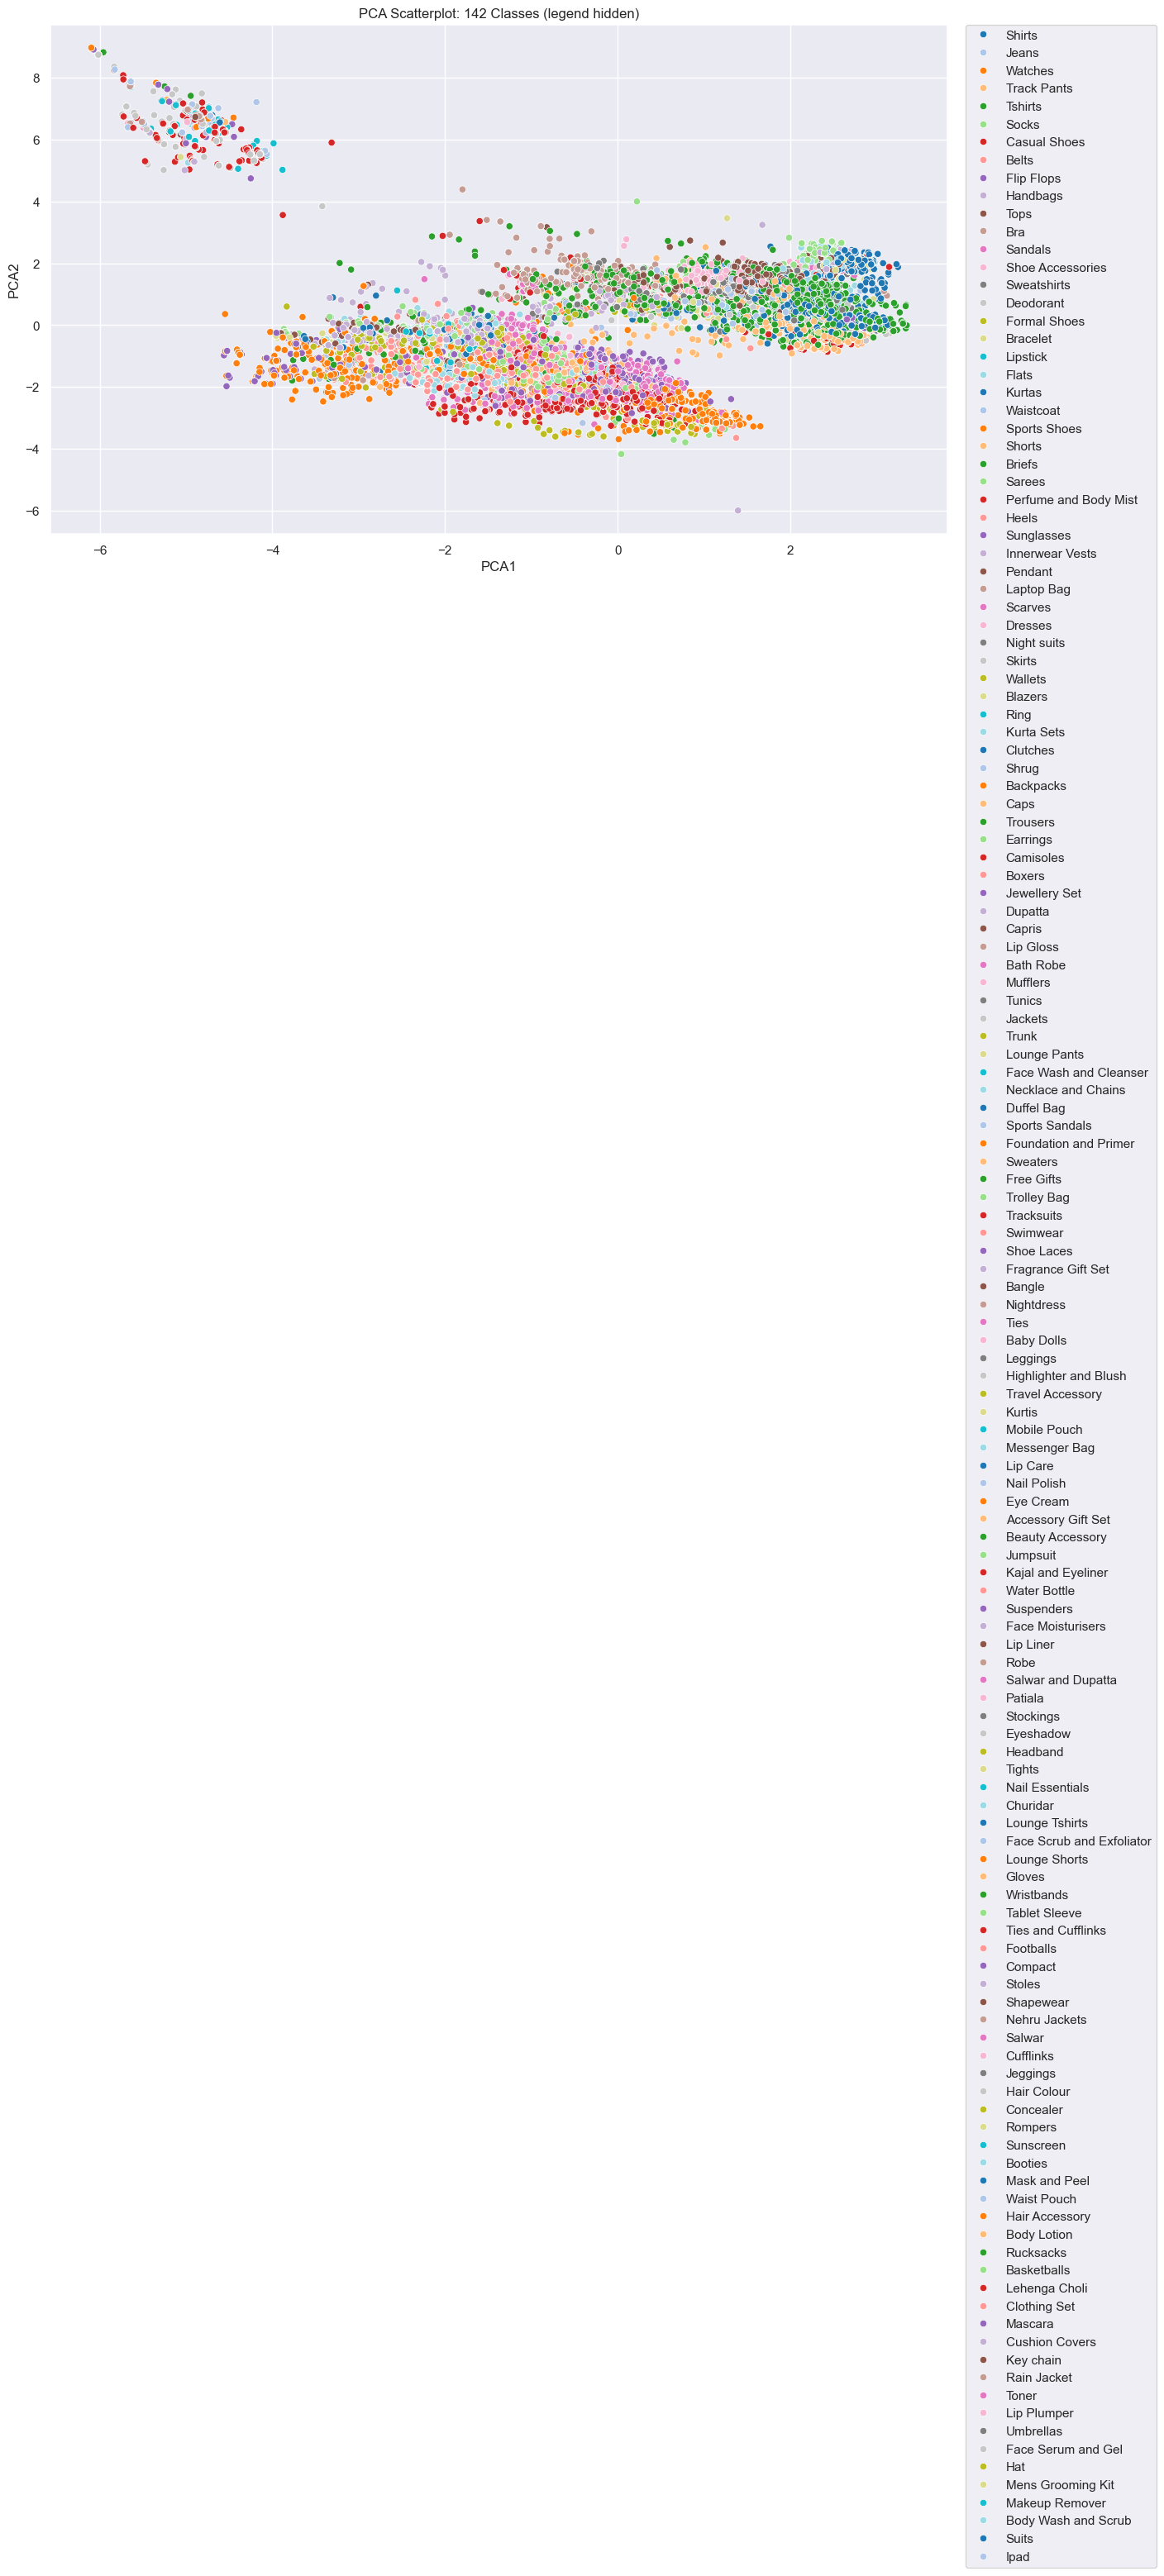

: 

: 

In [ ]:
# Plot PCA results
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='articleType', palette='tab20', legend='brief')
plt.title(f"PCA Scatterplot: {len(df_pca['articleType'].unique())} Classes (legend hidden)")
# Place the legend outside the plot on the right
plt.legend(
    bbox_to_anchor=(1.02, 1),   # (x, y) position (1.02 = a little right of axes)
    loc='upper left',           # which corner of legend box to use
    borderaxespad=0
)
plt.show()